# ML Analysis: Cross-selling effects

* Problem statement
  * The product category furniture does not produce many profits, even losses. Therefore, the questions arises if it is still useful to keep this product in the portfolio.
  * Generally, furniture has higher operational costs for logistics (storage, transportation).
  * Thus, the company could make a shift in the product portfolio.
* Approach
  * Analyse the cross-selling effects in the product portfolio using clustering.
  * Product-Level Clustering (Product Affinity/Market Basket Analysis)
    * uncover co-purchase patterns
    * co-occurrence matrix
  * Customer Segmentation based on Purchase Behavior
* Assumption:
  * It is still useful to keep the products in the portfolio, because what is a office stuff shop without furniture? It is going to entice customers. We need to quantify this anyhow and preferebly see that over time.
  * The product segment is growing.
* Further questions: 
  * How can profits be maximized?

In [840]:
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd
import yaml

In [841]:
import gower
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import RobustScaler, StandardScaler

In [842]:
with open('../config.yaml') as file:
    config = yaml.safe_load(file)

# Getting dem data

Features

* RFM Metrics (for overall customer value):
  * Recency: Days since last purchase (overall).
  * Frequency: Total number of purchases/orders.
  * Monetary: Total spend across all categories (total_spend_overall).
* Category-Specific Metrics:
  * Total_Spend_Category_X (e.g., Total_Spend_LowProfitCategory)
  * Number_of_Purchases_Category_X (frequency in that category)
  * Has_Purchased_Category_X (binary flag: 0 or 1)
  * Average_Order_Value_Category_X (if applicable)
* Breadth of Purchase:
  * Number_of_Unique_Product_Categories_Purchased
  * Number_of_Unique_Products_Purchased

In [843]:
db_path = Path(config['processed_data']['database_sqlite'])
query_path = Path(config['queries_path'])

with sqlite3.connect(db_path) as conn:
    
    with open(query_path.joinpath('create_views.sql'), 'r') as f:
        conn.executescript(f.read())

    with open(query_path.joinpath('select_data_for_product_segmentation.sql'), 'r') as f:
        # cur = conn.executescript(f.read())
        df = pd.read_sql_query(f.read(), conn)

In [844]:
df = df.set_index('CustomerID')        
df.head()

,NumOrders,Sales,AOV,Profit,Recency,SalesTechnology,SalesOfficeSupplies,SalesFurniture,NumOrdersTechnology,NumOrdersOfficeSupplies,...,SalesFurnitureProfitable,ProfitFurniture,HasBoughtFurniture,HasBoughtFurnitureNotProfitable,HasBoughtFurnitureProfitable,FracSalesTechnology,FracSalesOfficeSupplies,FracSalesFurniture,FracSalesFurnitureNotProfitable,FracSalesFurnitureProfitable
CustomerID,,,,,,,,,,,,,,,,,,,,,
AA-10315,5,5563.560,1112.712000,-362.8825,184.0,473.696,5075.304,14.560,2,8,...,14.560,6.2608,1,0,1,0.085143,0.912240,0.002617,0.000000,0.002617
AA-10375,9,1056.390,117.376667,277.3824,19.0,766.930,261.060,28.400,3,11,...,28.400,11.0760,1,0,1,0.725991,0.247125,0.026884,0.000000,0.026884
AA-10480,4,1790.512,447.628000,435.8274,259.0,689.940,625.272,475.300,2,8,...,27.460,108.4104,1,1,1,0.385331,0.349214,0.265455,0.250118,0.015336
AA-10645,6,5086.935,847.822500,857.8033,55.0,354.682,981.540,3750.713,2,8,...,1402.825,648.8834,1,1,1,0.069724,0.192953,0.737323,0.461553,0.275770
AB-10015,3,886.156,295.385333,129.3465,415.0,221.980,273.504,390.672,1,3,...,341.960,60.1937,1,1,1,0.250498,0.308641,0.440861,0.054970,0.385891


# Data Scanning

## Skew

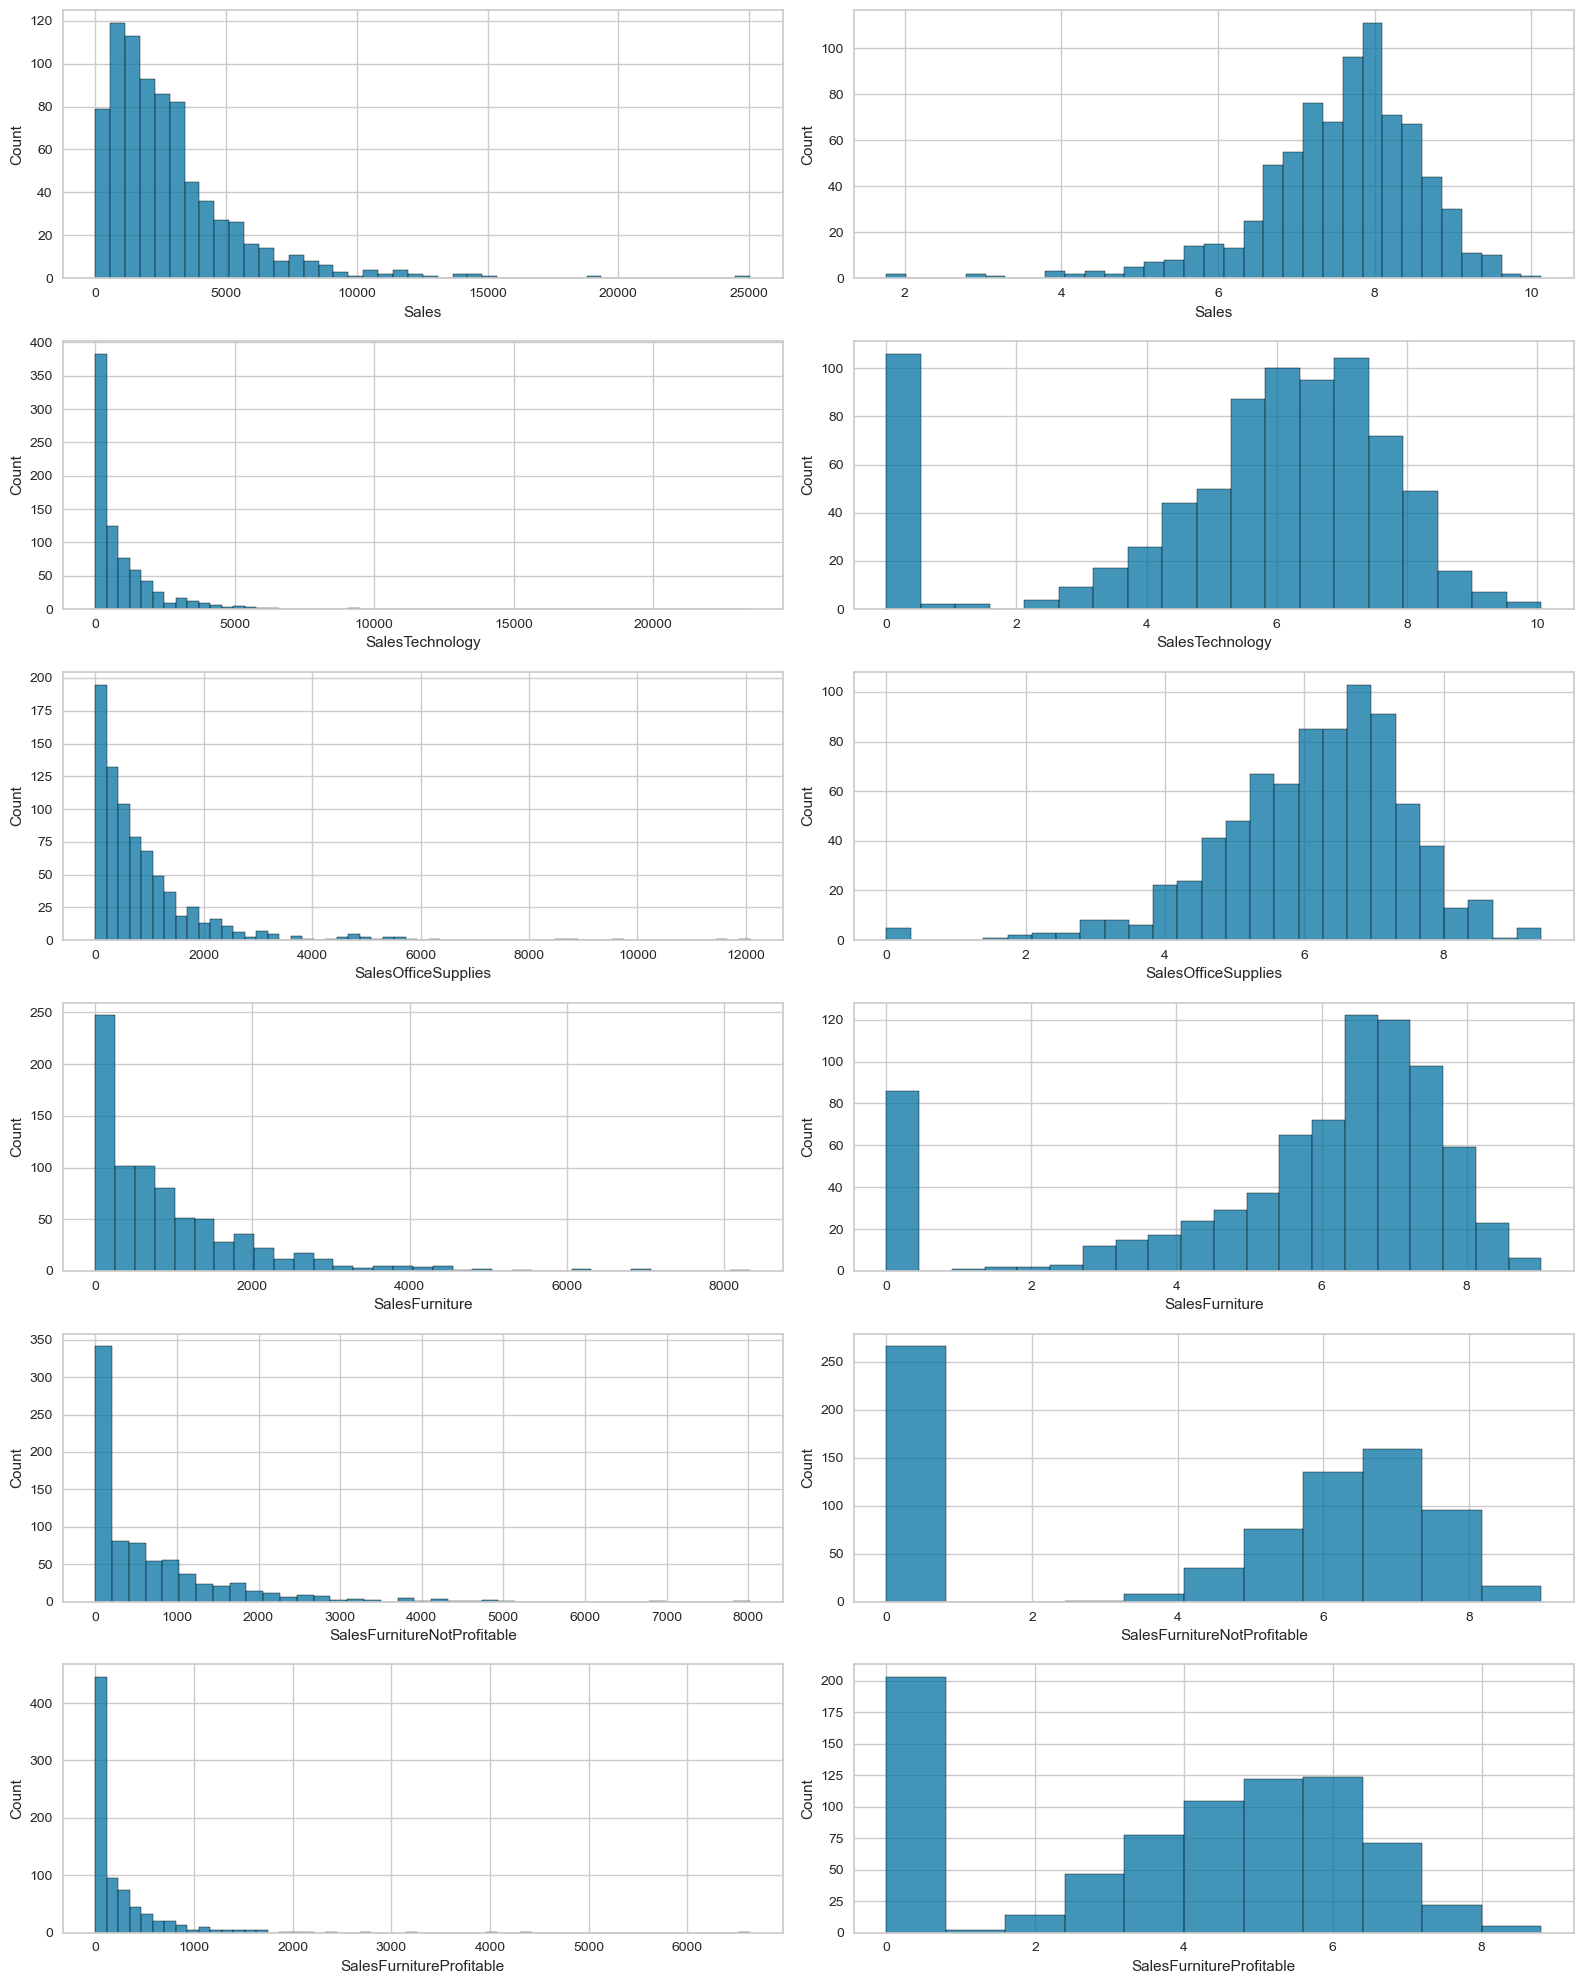

In [845]:
# check skew
# numeric_features = df.select_dtypes(include=np.number) 
numeric_features = [
    'Sales', 'SalesTechnology', 'SalesOfficeSupplies', 'SalesFurniture', 
    # 'SalesFurnitureChair', 'SalesFurnitureTables', 'SalesFurnitureFurnishings', 'SalesFurnitureBookcases'
    'SalesFurnitureNotProfitable', 'SalesFurnitureProfitable'
    ]

fig, axs = plt.subplots(len(numeric_features), 2, figsize=(16, 20))

for feat, ax in zip(numeric_features, axs[:,0]):
    sns.histplot(df[feat], ax=ax)

for feat, ax in zip(numeric_features, axs[:,1]):
    sns.histplot(np.log1p(df[feat]), ax=ax)

plt.tight_layout()

* Dem data is damn skewed: apply a log1p transformation to get dem data more nice.
* There are some outliers that might not be relevant for this analysis, since we want to see the usual customers behaviour.

## Feature Correlations

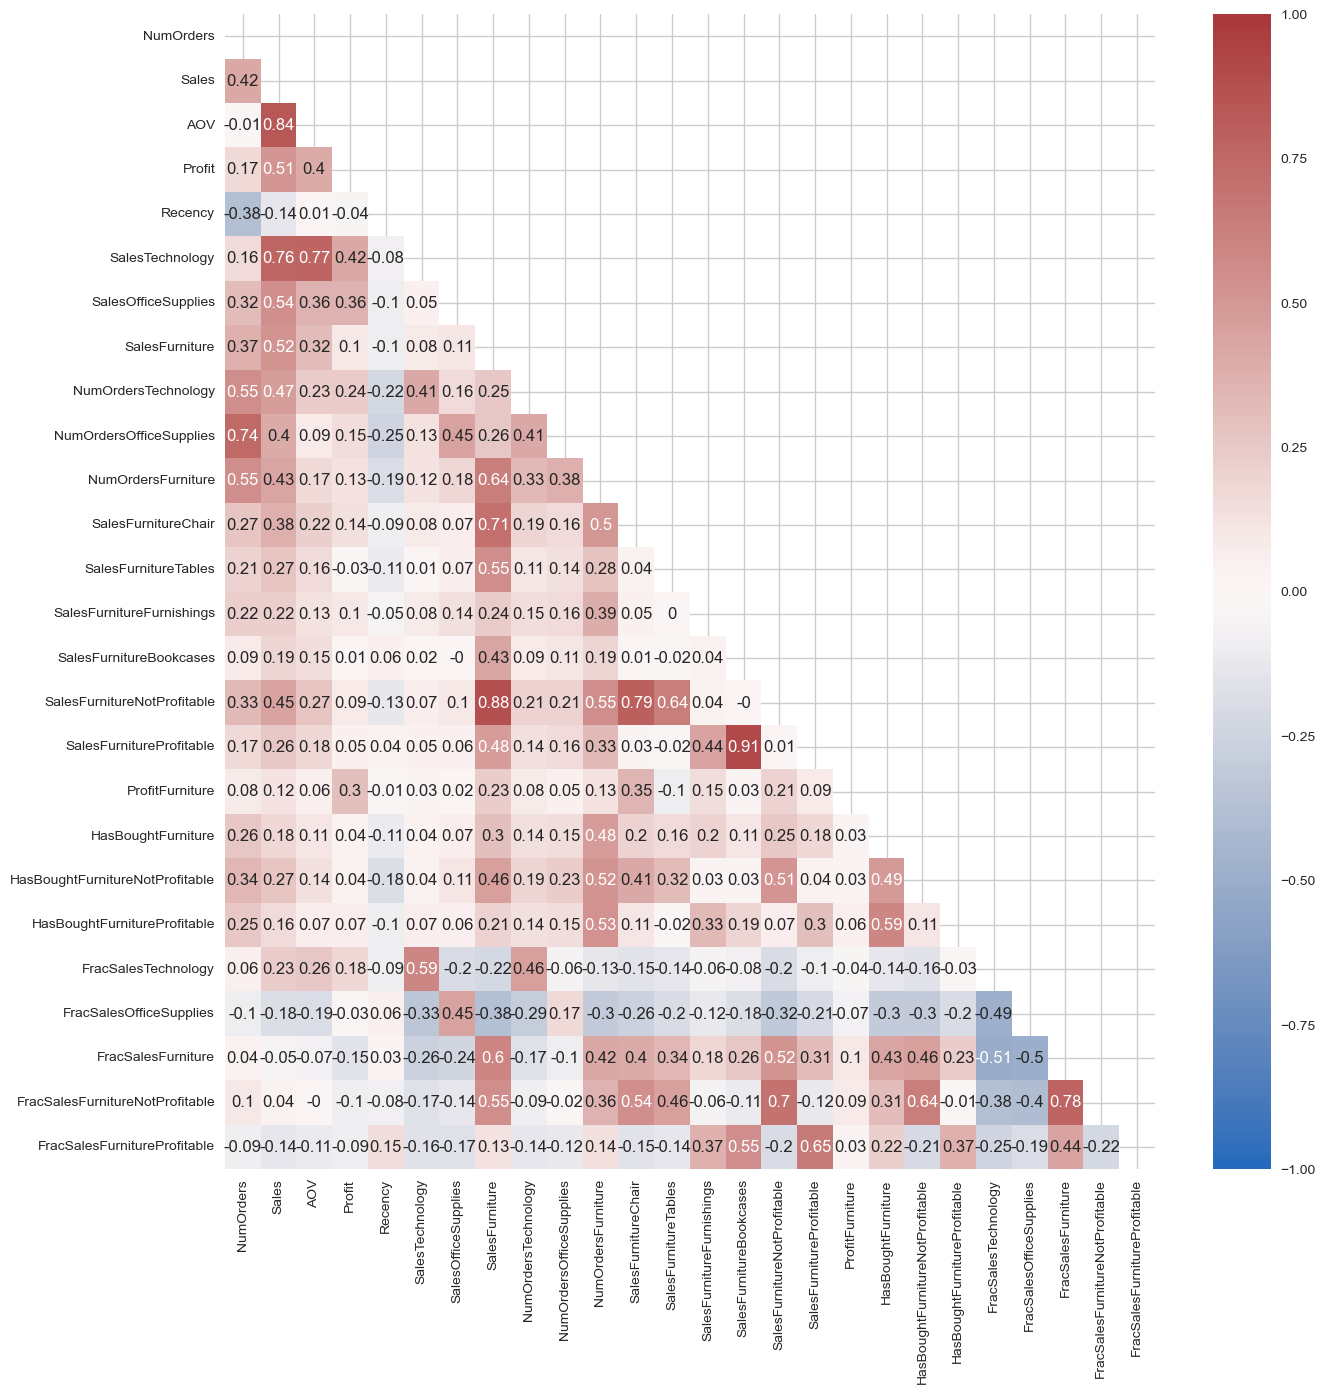

In [846]:
plt.subplots(figsize=(15,15))
matrix = df.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

# Machine Learning

In [1042]:
# re-run the notebook
if hasattr(df, 'Cluster'):
    df = df.drop(columns='Cluster')

## Feature Selection

In [1043]:
df.columns

Index(['NumOrders', 'Sales', 'AOV', 'Profit', 'Recency', 'SalesTechnology',
       'SalesOfficeSupplies', 'SalesFurniture', 'NumOrdersTechnology',
       'NumOrdersOfficeSupplies', 'NumOrdersFurniture', 'SalesFurnitureChair',
       'SalesFurnitureTables', 'SalesFurnitureFurnishings',
       'SalesFurnitureBookcases', 'SalesFurnitureNotProfitable',
       'SalesFurnitureProfitable', 'ProfitFurniture', 'HasBoughtFurniture',
       'HasBoughtFurnitureNotProfitable', 'HasBoughtFurnitureProfitable',
       'FracSalesTechnology', 'FracSalesOfficeSupplies', 'FracSalesFurniture',
       'FracSalesFurnitureNotProfitable', 'FracSalesFurnitureProfitable'],
      dtype='object')

In [1044]:
# Select features for clustering
features_excluded = [
    'NumOrders', 'Sales', 'AOV', 'Profit', 'Recency', 
    # 'SalesTechnology', 'SalesOfficeSupplies', 'SalesFurniture',
    'NumOrdersTechnology', 'NumOrdersOfficeSupplies', 
    'NumOrdersFurniture',
    'SalesFurnitureChair', 'SalesFurnitureTables', 'SalesFurnitureFurnishings', 'SalesFurnitureBookcases',
    'SalesFurnitureNotProfitable', 'SalesFurnitureProfitable',
    # 'ProfitFurniture',
    # 'HasBoughtFurniture',
    'HasBoughtFurnitureNotProfitable', 'HasBoughtFurnitureProfitable',
    'FracSalesTechnology', 'FracSalesOfficeSupplies', 'FracSalesFurniture',
    'FracSalesFurnitureNotProfitable', 'FracSalesFurnitureProfitable'
    ]

features = [col for col in df.columns if col not in features_excluded]
X = df[features]
X.head()

,SalesTechnology,SalesOfficeSupplies,SalesFurniture,ProfitFurniture,HasBoughtFurniture
CustomerID,,,,,
AA-10315,473.696,5075.304,14.560,6.2608,1
AA-10375,766.930,261.060,28.400,11.0760,1
AA-10480,689.940,625.272,475.300,108.4104,1
AA-10645,354.682,981.540,3750.713,648.8834,1
AB-10015,221.980,273.504,390.672,60.1937,1


In [1045]:
df.HasBoughtFurniture.mean()

np.float64(0.8915510718789408)

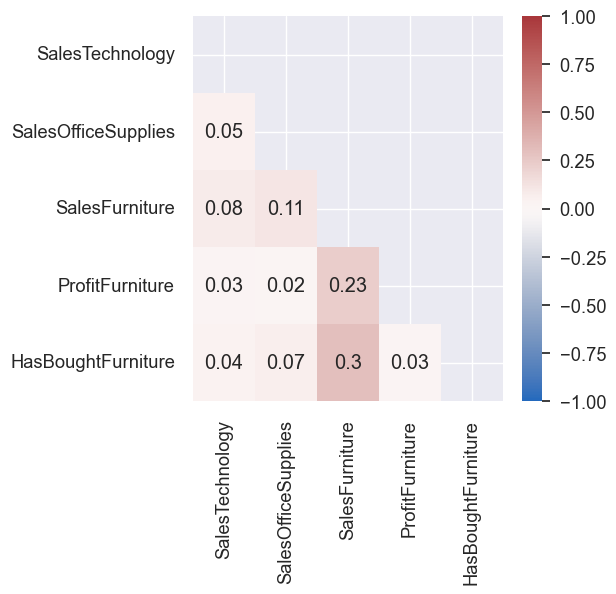

In [1046]:
plt.subplots(figsize=(5,5))
matrix = X.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

In [1047]:
# check variance / std of selected features
X.describe()

,SalesTechnology,SalesOfficeSupplies,SalesFurniture,ProfitFurniture,HasBoughtFurniture
count,793.000000,793.000000,793.000000,793.000000,793.000000
mean,1054.418705,906.742789,935.687005,23.267683,0.891551
std,1862.697540,1208.277422,1074.064212,234.108108,0.311143
min,0.000000,0.000000,0.000000,-1862.312400,0.000000
25%,102.104000,216.622000,160.185000,-26.179200,1.000000
50%,453.576000,549.394000,626.100000,10.393600,1.000000
75%,1297.572000,1106.421000,1347.200000,89.305200,1.000000
max,23481.508000,12081.258000,8332.090000,1146.487800,1.000000


## Pipelining

In [1048]:
# Gower distance transformation
from sklearn.base import BaseEstimator, TransformerMixin

class GowerDistanceTransformer(BaseEstimator, TransformerMixin):
    """
    A scikit-learn compatible transformer to compute the Gower distance matrix.
    Assumes X is a pandas DataFrame to handle mixed data types for Gower.
    """
    def __init__(self, feature_types=None):
        """
        Initializes the GowerDistanceTransformer.

        Parameters
        ----------
        feature_types : list, optional
            A list specifying the type of each feature.
            Example: ['numerical', 'categorical', 'numerical', 'categorical']
            If None, gower will attempt to infer types, but explicit definition
            is often safer for mixed data.
        """
        self.feature_types = feature_types
        self.X_train_ = None # To store training data for distance calculation

    def fit(self, X, y=None):
        """
        Stores the training data to calculate distances against in the transform step.
        """
        # Ensure X is a DataFrame for gower to handle mixed types properly
        if not isinstance(X, pd.DataFrame):
            # It's good practice to convert to DataFrame if your data might come
            # as numpy array from previous pipeline steps.
            # You might need to handle column names if they are lost.
            X_df = pd.DataFrame(X)
            # You might also need to infer or pass column dtypes here if they are critical
            # and lost from prior steps.
            print("Warning: Input X is not a Pandas DataFrame. Converting to DataFrame. "
                  "Ensure column types are correctly inferred or specified in feature_types.")
        else:
            X_df = X.copy()

        self.X_train_ = X_df
        return self

    def transform(self, X):
        """
        Computes the Gower distance matrix between X and the stored training data (X_train_).

        Parameters
        ----------
        X : array-like or pandas.DataFrame of shape (n_samples, n_features)
            The input data for which to compute distances.

        Returns
        -------
        distance_matrix : array of shape (n_samples, n_train_samples)
            The Gower distance matrix.
        """
        if self.X_train_ is None:
            raise RuntimeError("GowerDistanceTransformer has not been fitted yet.")

        # Ensure X is a DataFrame for gower
        if not isinstance(X, pd.DataFrame):
            X_df = pd.DataFrame(X)
            # Again, consider how to handle dtypes if they are critical and lost.
            print("Warning: Input X for transform is not a Pandas DataFrame. Converting to DataFrame.")
        else:
            X_df = X.copy()

        # Calculate Gower distance.
        # It's important that feature_types match the order of columns in X_train_ and X_df.
        distance_matrix = gower.gower_matrix(X_df, self.X_train_, feature_types=self.feature_types)
        return distance_matrix

In [1049]:
# Pre-processing: Scaling the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_scaled_df = pd.DataFrame(X_scaled, columns=df.columns, index=df.index)
# print("\nScaled Customer Features:")
# X_scaled_df

# build preprocessor for ML pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

features_log_and_scale = []
# if 'Sales' in features: features_log_and_scale.append('Sales')
# if 'SalesTechnology' in features: features_log_and_scale.append('SalesTechnology')
# if 'SalesOfficeSupplies' in features: features_log_and_scale.append('SalesOfficeSupplies')
# if 'SalesFurniture' in features: features_log_and_scale.append('SalesFurniture')

log_and_scale_pipeline = Pipeline([
    ('log1p', FunctionTransformer(np.log1p, validate=False)), # Apply log(1+x)
    ('scaler', RobustScaler()) # Then scale the log-transformed values
])

preprocessor = ColumnTransformer(
    transformers=[
        ('log_and_scale', log_and_scale_pipeline, features_log_and_scale),
        ('scale', StandardScaler(), [feat for feat in features if feat not in features_log_and_scale])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [1050]:
pd.DataFrame(preprocessor.fit_transform(X), index=X.index, columns=X.columns)

,SalesTechnology,SalesOfficeSupplies,SalesFurniture,ProfitFurniture,HasBoughtFurniture
CustomerID,,,,,
AA-10315,-0.311961,3.452181,-0.858150,-0.072691,0.34877
AA-10375,-0.154437,-0.534720,-0.845256,-0.052110,0.34877
AA-10480,-0.195796,-0.233099,-0.428911,0.363919,0.34877
AA-10645,-0.375895,0.061943,2.622564,2.674023,0.34877
AB-10015,-0.447182,-0.524415,-0.507753,0.157830,0.34877
...,...,...,...,...,...
XP-21865,-0.434733,0.340752,-0.115885,0.297101,0.34877
YC-21895,0.255243,2.396356,-0.755811,-0.035641,0.34877
YS-21880,-0.439650,3.905936,-0.069372,0.001642,0.34877


In [1051]:
kmeans_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clustering', KMeans(random_state=42, n_init='auto'))
])

## Determine Number of Clusters

In [1052]:
# Determine Optimal Number of Clusters (Elbow Method) 
km = []
inertia = []
silhouette = []
dbi = []
chs = []
max_num_clusters = 50 # len(df)-1
range_clusters = range(2, max_num_clusters)
X_scaled = kmeans_pipe.named_steps['preprocessor'].fit_transform(X)
for k in range_clusters: # K can't be more than number of samples
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    km.append(kmeans)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))
    dbi.append(davies_bouldin_score(X_scaled, kmeans.labels_))
    chs.append(calinski_harabasz_score(X_scaled, kmeans.labels_))

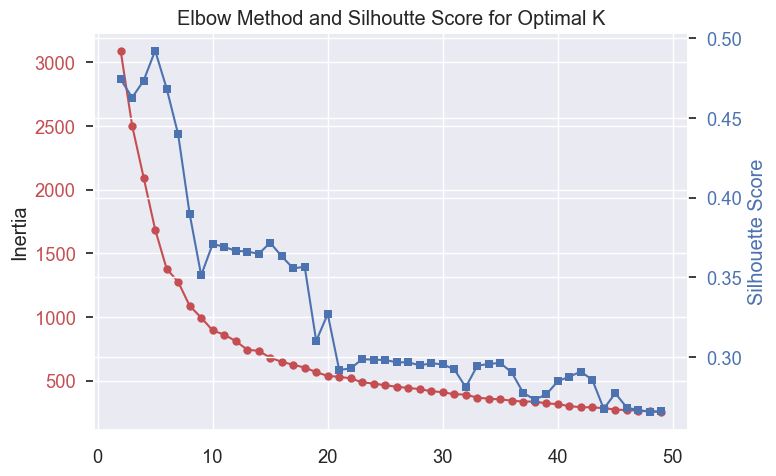

In [1053]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot temperature on the left y-axis
ax1.plot(range_clusters, inertia, 'r-o')
ax1.set_ylabel('Inertia')
ax1.tick_params(axis='y', labelcolor='r')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(range_clusters, silhouette, 'b-s')#, label='Electricity Consumption (kWh)')
ax2.set_ylabel('Silhouette Score', color='b')
ax2.tick_params(axis='y', labelcolor='b')


plt.title('Elbow Method and Silhoutte Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.grid(True)
plt.tight_layout()
plt.show()

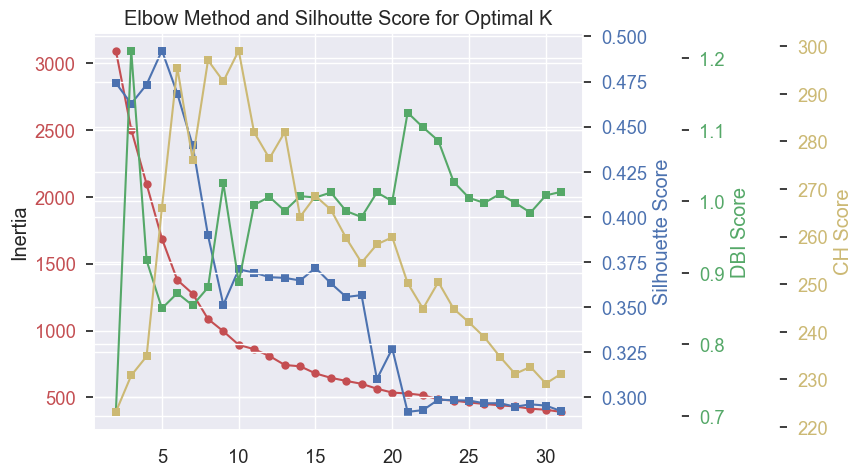

In [1054]:
fig, ax1 = plt.subplots(figsize=(10, 5))

n_clusters = 30

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()

ax1.spines.left.set_position(("axes", 0.))
ax2.spines.left.set_position(("axes", 0.))
ax3.spines.right.set_position(("axes", 1.2))
ax4.spines.right.set_position(("axes", 1.4))

ax3.spines.right.set_visible(True)
ax4.spines.right.set_visible(True)

# Plot temperature on the left y-axis
ax1.plot(range_clusters[:n_clusters], inertia[:n_clusters], 'r-o')
ax1.set_ylabel('Inertia')
ax1.tick_params(axis='y', labelcolor='r')

# Create a second y-axis for silhouette score
ax2.plot(range_clusters[:n_clusters], silhouette[:n_clusters], 'b-s')#, label='Electricity Consumption (kWh)')
ax2.set_ylabel('Silhouette Score', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Create a third y-axis for DBI Score
ax3.plot(range_clusters[:n_clusters], dbi[:n_clusters], 'g-s')#, label='Electricity Consumption (kWh)')
ax3.set_ylabel('DBI Score', color='g')
ax3.tick_params(axis='y', labelcolor='g')

# Create a third y-axis for CHI Score
ax4.plot(range_clusters[:n_clusters], chs[:n_clusters], 'y-s')#, label='Electricity Consumption (kWh)')
ax4.set_ylabel('CH Score', color='y')
ax4.tick_params(axis='y', labelcolor='y')

plt.title('Elbow Method and Silhoutte Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.grid(visible=False)
plt.tight_layout()
plt.show()

maximize Silhoutte, CH-Score
minimize DBI

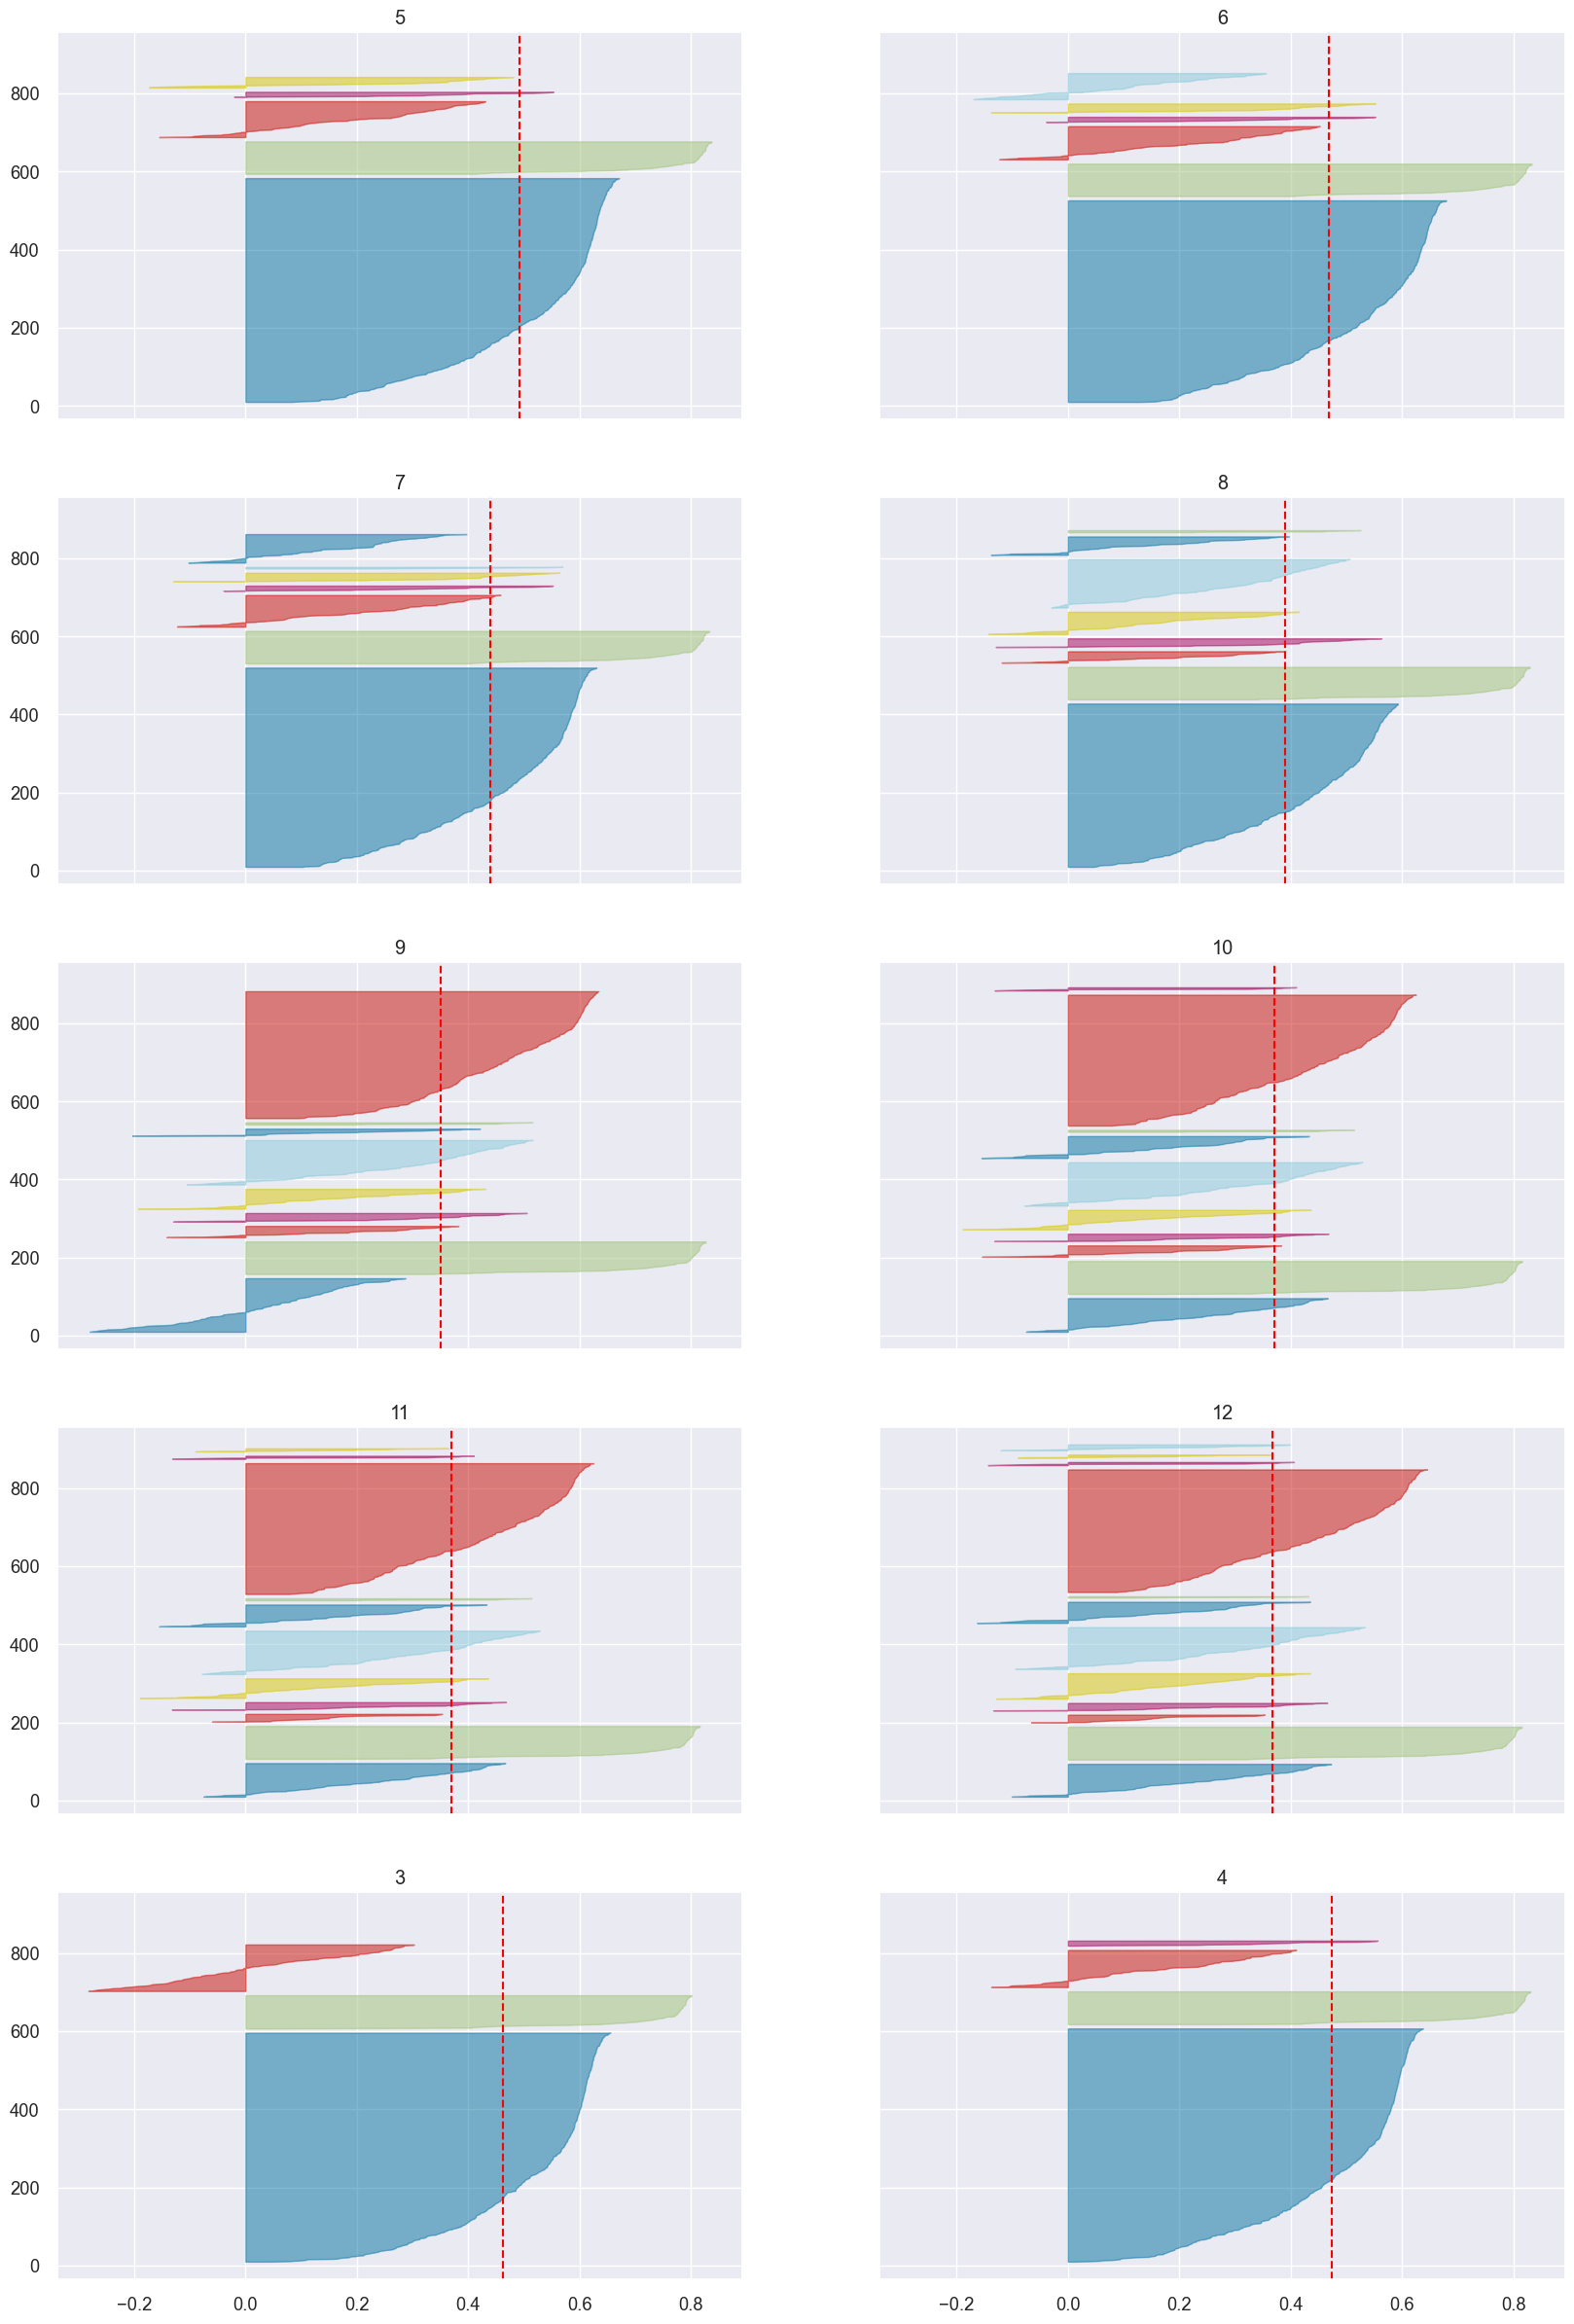

In [1055]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(5, 2, figsize=(20,30), sharex=True, sharey=True)

for i, k in enumerate(km[1:11]):
    '''
    Create KMeans instance for different number of clusters
    '''
    # km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(k, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_scaled)
    ax[q-1][mod].set_title(f'{k.n_clusters}')

In [1056]:
inertia_diff = pd.Series(inertia[:-1]) - pd.Series(inertia[1:])
inertia_diff.index = (inertia_diff.index+1)
inertia_diff

1     589.909378
2     407.935137
3     407.942464
4     308.643877
5     102.378475
6     188.960135
7      91.924522
8     101.267973
9      32.524448
10     50.677426
11     67.470099
12      9.737159
13     53.208914
14     32.899891
15     23.003035
16     21.681621
17     36.584414
18     28.978768
19      6.882685
20     12.879870
21     30.822522
22      9.748153
23     13.308984
24     11.812542
25      9.262450
26      9.112572
27     16.694532
28      7.835223
29     15.884000
30      2.362242
31     24.837387
32      7.360449
33      6.567929
34      8.926178
35      7.713810
36     -0.473410
37     14.893531
38      4.818773
39     16.402048
40      8.237941
41      1.074956
42      7.013775
43     10.395281
44      4.868922
45      4.114555
46      3.599130
47      5.888414
dtype: float64

## Perform Clustering and Analyse

In [1074]:
# select optimal number of clusters from the above plot
optimal_k = 5
print('Inertia Diff', inertia_diff[optimal_k])
print('Silhouette', silhouette[optimal_k-2])
print('DBI', dbi[optimal_k-2])
print('CHS', chs[optimal_k-2])

Inertia Diff 102.37847493990853
Silhouette 0.4921675125798049
DBI 0.8502619972097356
CHS 266.09475840734905


In [1075]:
# Perform K-Means Clustering
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df['Cluster'] = kmeans_model.fit_predict(X)

print(f"\nCustomer Data with {optimal_k} Clusters:")
df.head()


Customer Data with 5 Clusters:


,NumOrders,Sales,AOV,Profit,Recency,SalesTechnology,SalesOfficeSupplies,SalesFurniture,NumOrdersTechnology,NumOrdersOfficeSupplies,...,ProfitFurniture,HasBoughtFurniture,HasBoughtFurnitureNotProfitable,HasBoughtFurnitureProfitable,FracSalesTechnology,FracSalesOfficeSupplies,FracSalesFurniture,FracSalesFurnitureNotProfitable,FracSalesFurnitureProfitable,Cluster
CustomerID,,,,,,,,,,,,,,,,,,,,,
AA-10315,5,5563.560,1112.712000,-362.8825,184.0,473.696,5075.304,14.560,2,8,...,6.2608,1,0,1,0.085143,0.912240,0.002617,0.000000,0.002617,2
AA-10375,9,1056.390,117.376667,277.3824,19.0,766.930,261.060,28.400,3,11,...,11.0760,1,0,1,0.725991,0.247125,0.026884,0.000000,0.026884,0
AA-10480,4,1790.512,447.628000,435.8274,259.0,689.940,625.272,475.300,2,8,...,108.4104,1,1,1,0.385331,0.349214,0.265455,0.250118,0.015336,0
AA-10645,6,5086.935,847.822500,857.8033,55.0,354.682,981.540,3750.713,2,8,...,648.8834,1,1,1,0.069724,0.192953,0.737323,0.461553,0.275770,3
AB-10015,3,886.156,295.385333,129.3465,415.0,221.980,273.504,390.672,1,3,...,60.1937,1,1,1,0.250498,0.308641,0.440861,0.054970,0.385891,0


In [1076]:
df.columns

Index(['NumOrders', 'Sales', 'AOV', 'Profit', 'Recency', 'SalesTechnology',
       'SalesOfficeSupplies', 'SalesFurniture', 'NumOrdersTechnology',
       'NumOrdersOfficeSupplies', 'NumOrdersFurniture', 'SalesFurnitureChair',
       'SalesFurnitureTables', 'SalesFurnitureFurnishings',
       'SalesFurnitureBookcases', 'SalesFurnitureNotProfitable',
       'SalesFurnitureProfitable', 'ProfitFurniture', 'HasBoughtFurniture',
       'HasBoughtFurnitureNotProfitable', 'HasBoughtFurnitureProfitable',
       'FracSalesTechnology', 'FracSalesOfficeSupplies', 'FracSalesFurniture',
       'FracSalesFurnitureNotProfitable', 'FracSalesFurnitureProfitable',
       'Cluster'],
      dtype='object')

In [1077]:
# cluster profiling
cluster_profiles = df.groupby('Cluster').agg({
    'NumOrders':'sum', 'Sales':'sum', 'AOV':'mean', 'Profit':'sum', 'Recency':'mean', 'SalesTechnology':'sum',
    'SalesOfficeSupplies':'sum', 'SalesFurniture':'sum', 'NumOrdersTechnology':'sum',
    'NumOrdersOfficeSupplies':'sum', 'NumOrdersFurniture':'sum', 'SalesFurnitureChair':'sum',
    'ProfitFurniture':'sum', 
    'HasBoughtFurniture':'mean',
    'HasBoughtFurnitureNotProfitable':'mean', 'HasBoughtFurnitureProfitable':'mean'
})

print("\nCluster Profiles (Average Feature Values within each Cluster):")
cluster_profiles[[
    'Sales', 'Profit', 'AOV', #'ProfitFurniture',
#     'SalesTechnology','SalesOfficeSupplies', 'SalesFurniture'
    ] + features].round(2).sort_values('SalesFurniture', ascending=False)


Cluster Profiles (Average Feature Values within each Cluster):


,Sales,Profit,AOV,SalesTechnology,SalesOfficeSupplies,SalesFurniture,ProfitFurniture,HasBoughtFurniture
Cluster,,,,,,,,
3,568936.98,52098.53,621.54,111446.77,110039.51,347450.70,15087.11,1.00
0,982347.92,100356.55,306.81,308568.99,384742.88,289036.05,-805.96,0.86
4,463390.50,66823.57,955.76,309897.69,75866.33,77626.48,2388.31,0.92
2,183714.86,40638.41,1022.00,13822.62,144727.99,25164.25,1422.47,0.96
1,98810.60,26479.95,3259.81,92417.96,3670.32,2722.32,359.35,0.83


In [1078]:
cluster_profiles.columns

Index(['NumOrders', 'Sales', 'AOV', 'Profit', 'Recency', 'SalesTechnology',
       'SalesOfficeSupplies', 'SalesFurniture', 'NumOrdersTechnology',
       'NumOrdersOfficeSupplies', 'NumOrdersFurniture', 'SalesFurnitureChair',
       'ProfitFurniture', 'HasBoughtFurniture',
       'HasBoughtFurnitureNotProfitable', 'HasBoughtFurnitureProfitable'],
      dtype='object')

In [1079]:
cluster_profiles['SalesTechnology'] / cluster_profiles['Sales']

Cluster
0    0.314114
1    0.935304
2    0.075240
3    0.195886
4    0.668761
dtype: float64

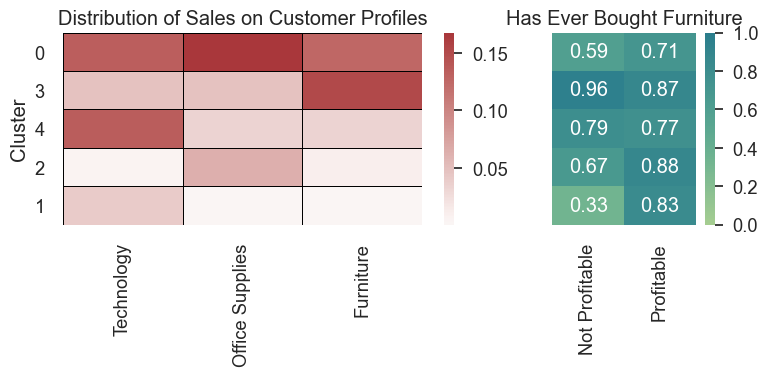

In [1093]:
sns.set_theme(font_scale=1.2)

matrix = cluster_profiles[[
    'Sales', 'SalesTechnology', 'SalesOfficeSupplies', 'SalesFurniture', 'ProfitFurniture', 
    'HasBoughtFurniture', 'HasBoughtFurnitureNotProfitable', 'HasBoughtFurnitureProfitable'
                           ]] .sort_values('Sales', ascending=False)
matrix['SalesTechnology'] /= cluster_profiles['Sales'].sum()
matrix['SalesOfficeSupplies'] /= cluster_profiles['Sales'].sum() # cluster_profiles['SalesOfficeSupplies'].sum()
matrix['SalesFurniture'] /= cluster_profiles['Sales'].sum() # cluster_profiles['SalesFurniture'].sum()
matrix['ProfitFurniture'] /= cluster_profiles['ProfitFurniture'].sum()

categories = ['Technology', 'Office Supplies', 'Furniture']

# mask = np.triu(np.ones_like(matrix, dtype=bool))
fig, ax = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [2.5, 1]}, figsize=(8,4))
sns.heatmap(matrix[['SalesTechnology', 'SalesOfficeSupplies', 'SalesFurniture']], center=0, cmap='vlag', ax=ax[0], linewidths=.5, linecolor='black', yticklabels=[], xticklabels=categories)#, mask=mask) vmax=1, vmin=-0.05, 
# sns.heatmap(matrix[['ProfitFurniture']], center=0, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax[1])#, mask=mask) vmax=1, vmin=-0.05, 
sns.heatmap(matrix[['HasBoughtFurnitureNotProfitable', 'HasBoughtFurnitureProfitable']], center=0.9, annot=True, vmax=1, vmin=0, cmap='crest', ax=ax[1], xticklabels=['Not Profitable', 'Profitable'])#, mask=mask) vmax=1, vmin=-0.05, 

ax[1].set_ylabel('')

ax[0].set_title('Distribution of Sales on Customer Profiles')
ax[1].set_title('Has Ever Bought Furniture')

plt.tight_layout()
plt.show()

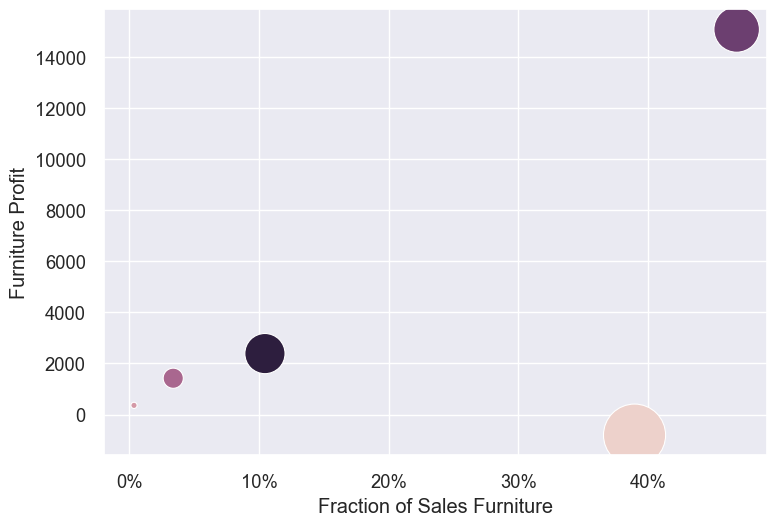

In [1081]:
cluster_profiles_plot = cluster_profiles.copy()
cluster_profiles_plot.SalesFurniture = cluster_profiles_plot.SalesFurniture / cluster_profiles_plot.SalesFurniture.sum()
# cluster_profiles_plot.ProfitFurniture = cluster_profiles_plot.ProfitFurniture / cluster_profiles_plot.ProfitFurniture.sum()

fig, ax = plt.subplots()

sns.scatterplot(
    data=cluster_profiles_plot.reset_index(),
    x="SalesFurniture",
    y="ProfitFurniture",
    size="Sales",
    hue="Cluster",
    legend=False,
    sizes=(20, 2000)
)

# Define a function to format the labels
def percent_formatter_func(x, pos):
    """
    Formats a number as a percentage.
    x: the tick value
    pos: the tick position (unused here, but required by FuncFormatter signature)
    """
    return f'{x:.0%}' # Formats as percentage with 1 decimal place
import matplotlib.ticker as mtick # Import the ticker module
ax.xaxis.set_major_formatter(mtick.FuncFormatter(percent_formatter_func))
# ax.yaxis.set_major_formatter(mtick.FuncFormatter(percent_formatter_func))

ax.set_xlabel('Fraction of Sales Furniture')
ax.set_ylabel('Furniture Profit')
# plt.grid(False)
# sns.despine()
plt.tight_layout()

In [1082]:
# Analyze 'Has_Purchased_LowProfitCatX' for each cluster
low_profit_presence = df.groupby('Cluster')[['Sales', 'Profit', 'HasBoughtFurniture']].agg({
    'Sales'                 : ('mean', 'sum'), 
    'Profit'                : ('mean', 'sum'), 
    'HasBoughtFurniture'    : 'mean'
    })

print("\nAverage 'HasBoughtFurniture' per Cluster (Proportion of Cluster buying it):")
low_profit_presence.sort_values(('Profit', 'sum'), ascending=False).round(2)


Average 'HasBoughtFurniture' per Cluster (Proportion of Cluster buying it):


Sales              Profit            HasBoughtFurniture
             mean        sum     mean        sum               mean
Cluster                                                            
0         1738.67  982347.92   177.62  100356.55               0.86
4         6347.82  463390.50   915.39   66823.57               0.92
3         4551.50  568936.98   416.79   52098.53               1.00
2         7654.79  183714.86  1693.27   40638.41               0.96
1        16468.43   98810.60  4413.32   26479.95               0.83

# What is the Customer Group with lowest Profit in Furniture doing? 

In [1083]:
%store -r dashboard_data

In [1084]:
def show_value_counts_pie(value_counts, ax):
    return ax.pie(value_counts.values, labels=value_counts.index);

In [1085]:
dashboard_data.Category.value_counts()

Category
Office Supplies    6022
Furniture          2119
Technology         1845
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x173e542e5d0>,
 [Text(-0.43873832028721954, 1.0087163557271932, 'Office Supplies'),
  Text(-0.15435213456906957, -1.089116806662156, 'Furniture'),
  Text(0.9371727471626178, -0.5759403111223178, 'Technology')])

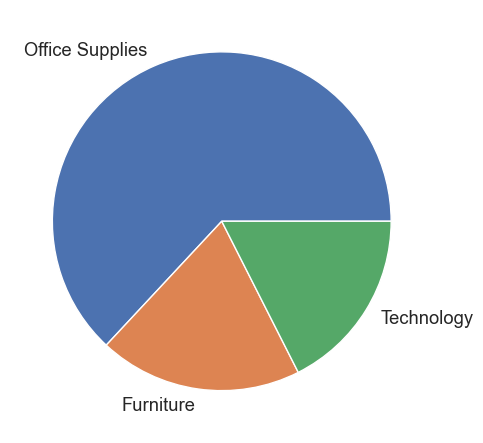

In [1086]:
mask_cluster = dashboard_data.CustomerID.isin(df[df.Cluster == 0].index)
mask_cat_furniture = dashboard_data.Category == 'Furniture'

fig, ax = plt.subplots()

data = dashboard_data[mask_cluster].Category.value_counts()
show_value_counts_pie(data, ax)

In [1087]:
dashboard_data[mask_cluster & mask_cat_furniture].Discount.value_counts()

Discount
0.00    472
0.20    363
0.30    125
0.60     90
0.50     37
0.40     34
0.10     34
0.15     26
0.32     12
0.70     10
0.45      7
Name: count, dtype: int64

<Axes: >

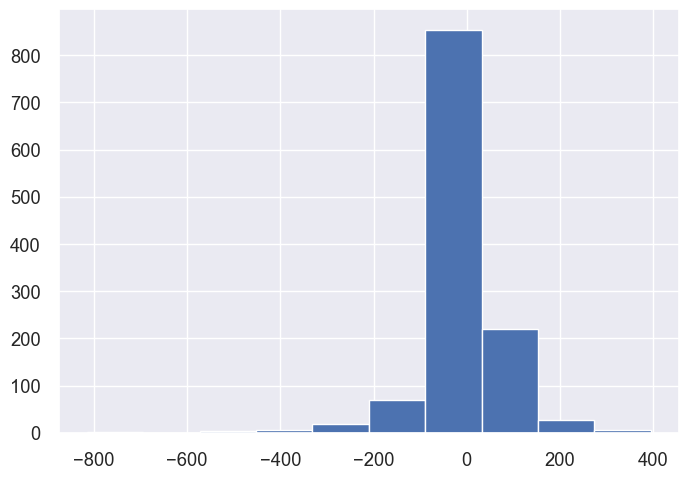

In [1088]:
dashboard_data[mask_cluster & mask_cat_furniture].Profit.hist()

In [1089]:
dashboard_data[mask_cluster & mask_cat_furniture & (dashboard_data.Profit<0)].Discount.value_counts()

Discount
0.30    119
0.20     97
0.60     90
0.50     37
0.40     34
0.32     12
0.70     10
0.15      9
0.45      7
0.10      3
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x173f7114a50>,
 [Text(1.0261729400883663, 0.39619325717432163, 'Global Ergonomic Managers Chair'),
  Text(0.5003602557175032, 0.9796119713939367, 'SAFCO Arco Folding Chair'),
  Text(-0.25847626581170696, 1.0692006453477456, 'Hon Every-Day Series Multi-Task Chairs'),
  Text(-0.8726543340298314, 0.6696823226716917, 'Chromcraft Round Conference Tables'),
  Text(-1.099981513761329, 0.006377255156830689, 'Bevis Oval Conference Table, Walnut'),
  Text(-0.8969991088488688, -0.6367044830408652, 'Global Leather Highback Executive Chair with Pneumatic Height Adjustment, Black'),
  Text(-0.3901488880838337, -1.0284861910239478, 'Bretford CR4500 Series Slim Rectangular Table'),
  Text(0.22671618315045783, -1.0763827257521779, 'Office Impressions End Table, 20-1/2"H x 24"W x 20"D'),
  Text(0.7631161375612019, -0.7922460227692362, 'Bevis Round Bullnose 29" High Table Top'),
  Text(1.0616188726657836, -0.2880370969160589, 'Global High-Back Leather Tilter, Burgundy')])

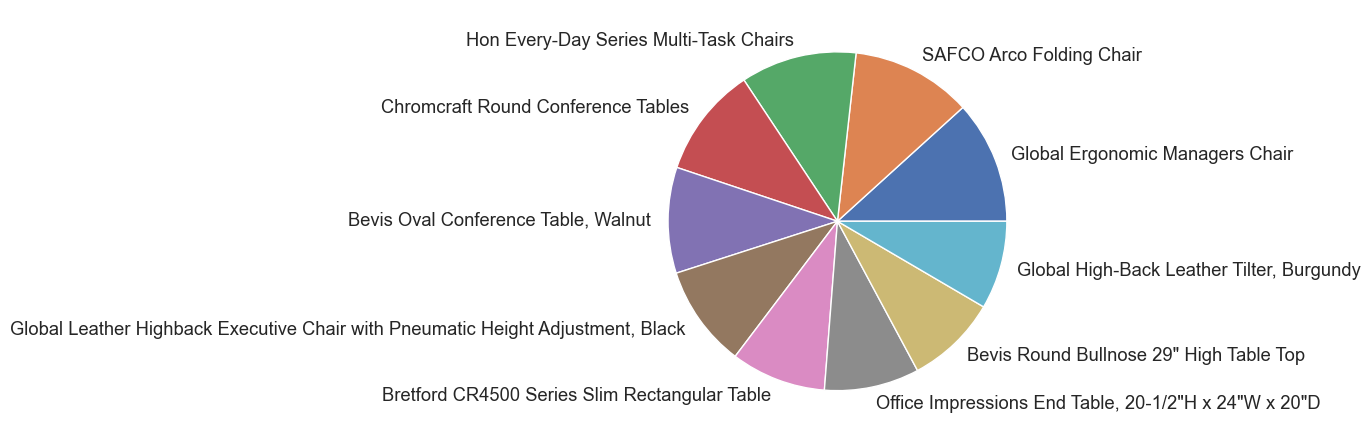

In [1090]:
data = dashboard_data[mask_cluster & mask_cat_furniture].groupby('ProductName').Sales.sum()#value_counts()


fig, ax = plt.subplots()

show_value_counts_pie(data.sort_values(ascending=False).head(10), ax)